## Imports and Set up

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from scipy import integrate, signal

In [2]:
# Set font size of plot elements\n",
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Function Definitions

In [3]:
def temp_from_photons(ω_c, num_photons):
    hbar_ov_k = 7.639e-12 
    return hbar_ov_k * ω_c / np.log(1 / num_photons + 1)

In [4]:
def photons_from_temp(ω_c, temp):
    hbar_ov_k = 7.639e-12
    return (np.exp(hbar_ov_k * ω_c / temp) - 1) ** -1

In [5]:
def output_spectrum_a(ω, κ, γ, ϕ, r, g, Δ, nT, nc, β, Sϕ=0):
    """
    Function for calculation the output spectrum from port 1 (i.e. reflection) using input/output theory with a coherent input source
    :param ω:  the frequency
    :param κ:  the output coupling rate of the cavity
    :param γ:  the internal loss rate of the cavity
    :param r:  the inhomogenous spreading of the spins
    :param g:  the coupling strength between the cavity and the spin ensemble
    :param Δ:  the detuning between the cavity and the spins
    :param nT: the number of thermal photons in the cavity
    :param nc: the effective number of photons in the spin bath
    :param β:  the amplitude of the coherent state <n> = |β|^2
    :param Sϕ: the phase noise spectrum
    :return:   the output spectrum (photons / freq)
    """
    # Define the terms of the numerator of the first term
    a = ((r ** 2 / 4) + ω ** 2) * (κ * γ * nT + κ * ϕ)
    b = κ * r * g ** 2 * nc
    c = np.abs(((κ - γ - ϕ) / 2 + 1j * (ω - Δ)) * (r / 2 - 1j * ω) - g ** 2) ** 2 * nT
    num = a + b + c

    # Define the denominator of the first term
    den = np.abs(((κ + γ + ϕ) / 2 - 1j * (ω - Δ)) * (r / 2 - 1j * ω) + g ** 2) ** 2

    # Define the second term
    snd_term_num = np.abs(((κ - γ - ϕ) / 2 + 1j * (ω - Δ)) * (r / 2 - 1j * ω) - g ** 2) ** 2 
    snd_term_den = np.abs(((κ + γ + ϕ) / 2 - 1j * (ω - Δ)) * (r / 2 - 1j * ω) + g ** 2) ** 2
    snd_term = snd_term_num / snd_term_den * (np.abs(β) ** 2 * signal.unit_impulse(ω.shape[0], 'mid') + Sϕ)

    # return
    return num / den + snd_term

In [6]:
def output_spectrum_e(ω, κ, γ, ϕ, r, g, Δ, nT, nc, β, Sϕ=0):
    """
    Function for calculation the output spectrum from port 2 (i.e. transmission) using input/output theory with a coherent input source
    :param ω:  the frequency
    :param κ:  the output coupling rate of the cavity
    :param γ:  the internal loss rate of the cavity
    :param r:  the inhomogenous spreading of the spins
    :param g:  the coupling strength between the cavity and the spin ensemble
    :param Δ:  the detuning between the cavity and the spins
    :param nT: the number of thermal photons in the cavity
    :param nc: the effective number of photons in the spin bath
    :param β:  the amplitude of the coherent state <n> = |β|^2
    :param Sϕ: the phase noise spectrum
    :return:   the output spectrum (photons / freq)
    """
    # Define the terms of the numerator of the first term
    a = ((r ** 2 / 4) + ω ** 2) * ϕ * (κ + γ) * nT
    b = ϕ * r * g ** 2 * nc
    c = np.abs(((ϕ - κ - γ) / 2 + 1j * (ω - Δ)) * (r / 2 - 1j * ω) - g ** 2) ** 2
    num = a + b + c

    # Define the denominator of the first term
    den = np.abs(((κ + γ + ϕ) / 2 - 1j * (ω - Δ)) * (r / 2 - 1j * ω) + g ** 2) ** 2

    # Define the second term
    snd_term_num = ϕ * κ * r ** 2
    snd_term_den = 4 * np.abs(((κ + γ + ϕ) / 2 - 1j * (ω - Δ)) * (r / 2 - 1j * ω) + g ** 2) ** 2
    snd_term = snd_term_num / snd_term_den * (np.abs(β) ** 2 * signal.unit_impulse(ω.shape[0], 'mid') + Sϕ)

    # return
    return num / den + snd_term

In [7]:
def output_spectrum_a_no_nv(ω, κ, γ, ϕ, Δ, nT, β, Sϕ=0):
    """
    Function for calculation the output spectrum from port 1 (i.e. reflection) using input/output theory with a coherent input source
    and no NV ensemble
    :param ω:  the frequency
    :param κ:  the output coupling rate of the cavity
    :param γ:  the internal loss rate of the cavity
    :param Δ:  the detuning between the cavity and the spins
    :param nT: the number of thermal photons in the cavity
    :param β:  the amplitude of the coherent state <n> = |β|^2
    :param Sϕ: the phase noise spectrum
    :return:   the output spectrum (photons / freq)
    """
    # Define the terms of the numerator of the first term
    a = κ * γ * nT + κ * ϕ
    b = np.abs((κ - γ - ϕ) / 2 + 1j * (ω - Δ)) ** 2 * nT
    num = a + b

    # Define the denominator of the first term
    den = np.abs((κ + γ + ϕ) / 2 - 1j * (ω - Δ)) ** 2

    # Define the second term
    snd_term_num = np.abs((κ - γ - ϕ) / 2 + 1j * (ω - Δ)) ** 2 
    snd_term_den = np.abs((κ + γ + ϕ) / 2 - 1j * (ω - Δ)) ** 2
    snd_term = snd_term_num / snd_term_den * (np.abs(β) ** 2 * signal.unit_impulse(ω.shape[0], 'mid') + Sϕ)

    # return
    return num / den + snd_term

In [8]:
def output_spectrum_e_no_nv(ω, κ, γ, ϕ, Δ, nT, β, Sϕ=0):
    """
    Function for calculation the output spectrum from port 2 (i.e. transmission) using input/output theory with a coherent input source
    and no NV ensemble
    :param ω:  the frequency
    :param κ:  the output coupling rate of the cavity
    :param γ:  the internal loss rate of the cavity
    :param Δ:  the detuning between the cavity and the spins
    :param nT: the number of thermal photons in the cavity
    :param β:  the amplitude of the coherent state <n> = |β|^2
    :param Sϕ: the phase noise spectrum
    :return:   the output spectrum (photons / freq)
    """
    # Define the terms of the numerator of the first term
    a = ϕ * (κ + γ) * nT
    b = np.abs((ϕ - κ - γ) / 2 + 1j * (ω - Δ)) ** 2
    num = a + b

    # Define the denominator of the first term
    den = np.abs((κ + γ + ϕ) / 2 - 1j * (ω - Δ)) ** 2

    # Define the second term
    snd_term_num = ϕ * κ
    snd_term_den = np.abs((κ + γ + ϕ) / 2 + 1j * Δ) ** 2
    snd_term = snd_term_num / snd_term_den * (np.abs(β) ** 2 * signal.unit_impulse(ω.shape[0], 'mid') + Sϕ)

    # return
    return num / den + snd_term

## Initial Testing

In [9]:
# First define the usual parameters - we'll start at room temperature for now
ωc = 2.87 * 2 * np.pi * 1e9
g = 2 * np.pi * 197.7e3
r = 2 * np.pi * 229e3
γ = 2 * np.pi * 140e3
κ = 2 * np.pi * 185.1e3
P = 0.8
nc = 0.5 * (1 - P) / P
T = 5
nT = photons_from_temp(ωc, T)

First test is to see if we can successfully recreate the output spectrum plot if we have 0 extra input

In [10]:
# Define the values of ω and Δ that we need
ω = np.linspace(-1.5, 1.5, 1000) * 2 * np.pi * 1e6
Δ = np.linspace(-4, 4, 1000) * 2 * np.pi * 1e6

# Create the meshgrid
ωm, Δm = np.meshgrid(ω, Δ)

In [11]:
# Now calculate the output spectrum
output_spec = output_spectrum_a(ωm, κ, γ, 0, r, g, Δm, nT, nc, 0)

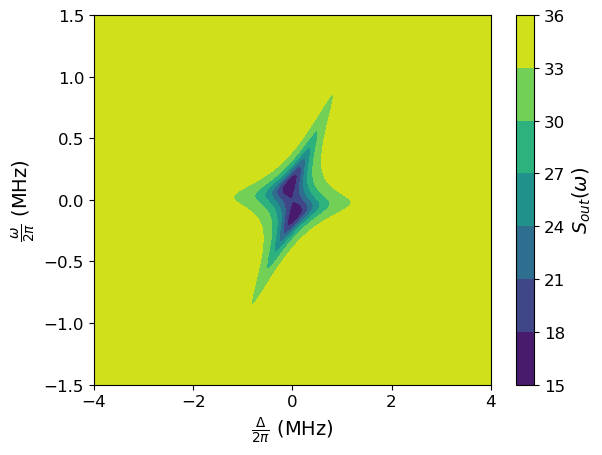

In [12]:
# And plot
plt.contourf(Δm / (2 * np.pi * 1e6), ωm / (2 * np.pi * 1e6), output_spec)
plt.xlabel("$\\frac{\\Delta}{2\\pi}$ (MHz)")
plt.ylabel("$\\frac{\\omega}{2\\pi}$ (MHz)")
plt.colorbar(label="$S_{out}(\\omega)$")

Now calculate the output spectrum of both ports

In [13]:
# Define the port 2 coupling as the average of the other two damping rates
ϕ = (κ + γ) / 2

In [14]:
# Calculate the output spectra
output_1 = output_spectrum_a(ωm, κ, γ, ϕ, r, g, Δm, nT, nc, 0)
output_2 = output_spectrum_e(ωm, κ, γ, ϕ, r, g, Δm, nT, nc, 0)

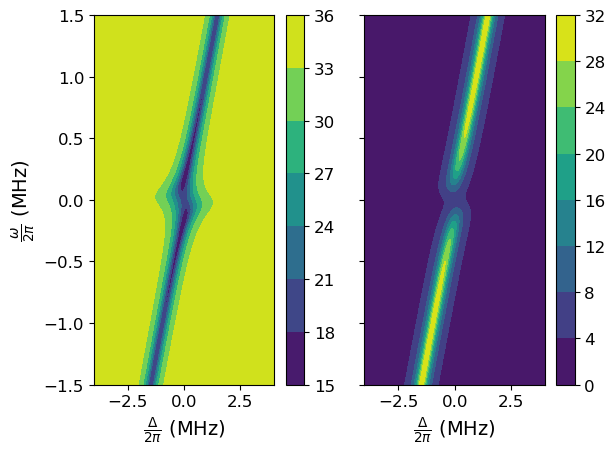

In [15]:
# Plot the results
fig = plt.figure(1)
ax = fig.subplots(1, 2, sharex='all', sharey='all')
im1 = ax[0].contourf(Δm / (2 * np.pi * 1e6), ωm / (2 * np.pi * 1e6), output_1)
ax[0].set_xlabel("$\\frac{\\Delta}{2\\pi}$ (MHz)")
ax[0].set_ylabel("$\\frac{\\omega}{2\\pi}$ (MHz)")
fig.colorbar(im1)

im2 = ax[1].contourf(Δm / (2 * np.pi * 1e6), ωm / (2 * np.pi * 1e6), output_2)
ax[1].set_xlabel("$\\frac{\\Delta}{2\\pi}$ (MHz)")
fig.colorbar(im2)

Now what if we add a coherent drive?

In [16]:
# Define the average number of photons in the coherent input
coh_n = 1e10
β = np.sqrt(coh_n)

In [17]:
# Calculate the output spectra
output_1 = output_spectrum_a(ωm, κ, γ, ϕ, r, g, Δm, nT, nc, β)
output_2 = output_spectrum_e(ωm, κ, γ, ϕ, r, g, Δm, nT, nc, β)

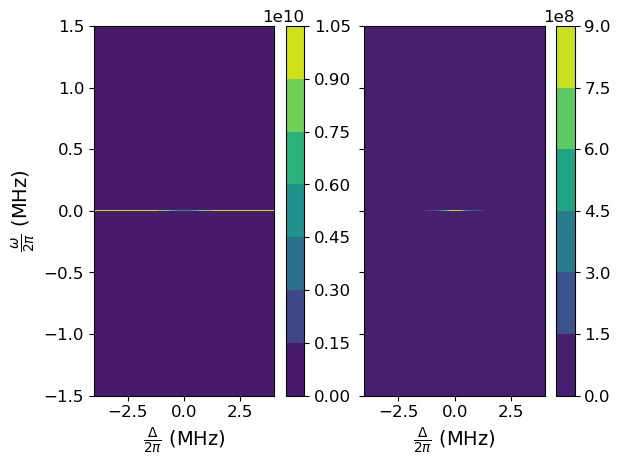

In [18]:
# Plot the results
fig = plt.figure(1)
ax = fig.subplots(1, 2, sharex='all', sharey='all')
im1 = ax[0].contourf(Δm / (2 * np.pi * 1e6), ωm / (2 * np.pi * 1e6), output_1)
ax[0].set_xlabel("$\\frac{\\Delta}{2\\pi}$ (MHz)")
ax[0].set_ylabel("$\\frac{\\omega}{2\\pi}$ (MHz)")
fig.colorbar(im1)

im2 = ax[1].contourf(Δm / (2 * np.pi * 1e6), ωm / (2 * np.pi * 1e6), output_2)
ax[1].set_xlabel("$\\frac{\\Delta}{2\\pi}$ (MHz)")
fig.colorbar(im2)

What if we look at 0 detuning?

In [19]:
# Calculate the output spectra
output_1 = output_spectrum_a(ω, κ, γ, ϕ, r, g, 0, nT, nc, β)
output_2 = output_spectrum_e(ω, κ, γ, ϕ, r, g, 0, nT, nc, β)
test = output_spectrum_e(ω, κ, γ, ϕ, r, g, 0, nT, nc, 0)

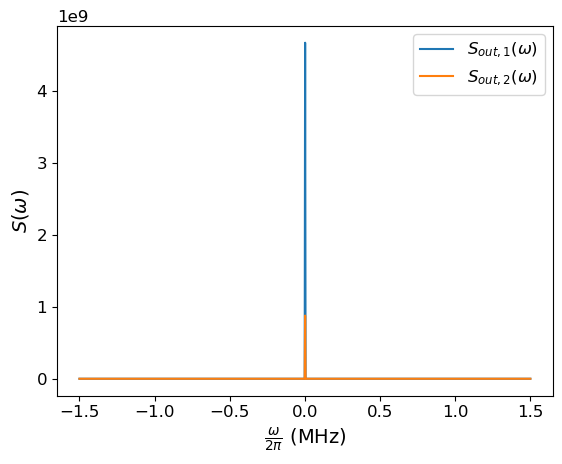

In [20]:
# Plot the results
plt.plot(ω / (2 * np.pi * 1e6), output_1, label='$S_{out,1}(\\omega)$')
plt.plot(ω / (2 * np.pi * 1e6), output_2, label='$S_{out,2}(\\omega)$')
plt.xlabel("$\\frac{\\omega}{2\\pi}$ (MHz)")
plt.ylabel("$S(\\omega)$")
plt.legend()

As a check, we can turn off the NV ensemble and the internal loss rate of the cavity.  Then the only input would be the vacuum noise on port 2 and the thermal noise and coherent input on port 1.

In [21]:
# Calculate the output spectra
output_1 = output_spectrum_a_no_nv(ω, κ, 0, ϕ, 0, nT, β)
output_2 = output_spectrum_e_no_nv(ω, κ, 0, ϕ, 0, nT, β)

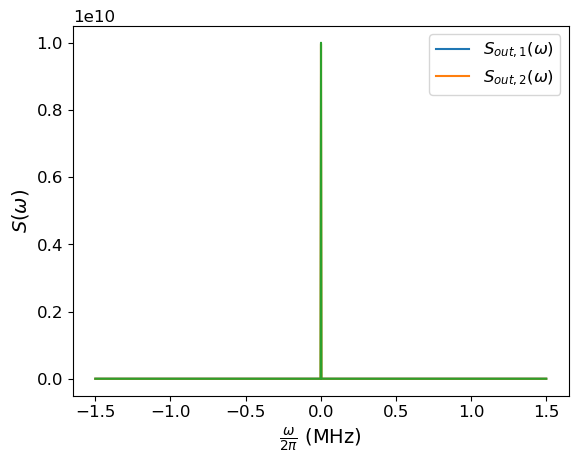

In [22]:
# Plot the results
plt.plot(ω / (2 * np.pi * 1e6), output_1, label='$S_{out,1}(\\omega)$')
plt.plot(ω / (2 * np.pi * 1e6), output_2, label='$S_{out,2}(\\omega)$')
plt.plot(ω / (2 * np.pi * 1e6), output_1 + output_2)
plt.xlabel("$\\frac{\\omega}{2\\pi}$ (MHz)")
plt.ylabel("$S(\\omega)$")
plt.legend()

In [23]:
(output_1 + output_2)[0] / (nT + 1 + np.abs(β) ** 2)

3.6799379094708993e-09

So the ratio of the sum of the outputs to the sum of the inputs is 1 as expected.  

Adding back in the internal loss rate, we should only be able to get the same ratio if we include another output term $b_{out}$.

In [24]:
def output_spectrum_c_no_nv(ω, κ, γ, ϕ, Δ, nT, β, Sϕ=0):
    """
    Function for calculation the output spectrum from port 3 (i.e. internal loss) using input/output theory with a coherent input source
    and no NV ensemble
    :param ω:  the frequency
    :param κ:  the output coupling rate of the cavity
    :param γ:  the internal loss rate of the cavity
    :param Δ:  the detuning between the cavity and the spins
    :param nT: the number of thermal photons in the cavity
    :param β:  the amplitude of the coherent state <n> = |β|^2
    :param Sϕ: the phase noise spectrum
    :return:   the output spectrum (photons / freq)
    """
    # Define the terms of the numerator of the first term
    a = γ * κ * nT + γ * ϕ
    b = np.abs((γ - κ - ϕ) / 2 + 1j * (ω - Δ)) ** 2 * nT
    num = a + b

    # Define the denominator of the first term
    den = np.abs((κ + γ + ϕ) / 2 - 1j * (ω - Δ)) ** 2

    # Define the second term
    snd_term_num = γ * κ
    snd_term_den = np.abs((κ + γ + ϕ) / 2 - 1j * (ω - Δ)) ** 2
    snd_term = snd_term_num / snd_term_den * (np.abs(β) ** 2 * signal.unit_impulse(ω.shape[0], 'mid') + Sϕ)

    # return
    return num / den + snd_term

In [25]:
# Calculate the output spectra
output_1 = output_spectrum_a_no_nv(ω, κ, γ, ϕ, 0, nT, β)
output_2 = output_spectrum_e_no_nv(ω, κ, γ, ϕ, 0, nT, β)
output_3 = output_spectrum_c_no_nv(ω, κ, γ, ϕ, 0, nT, β)

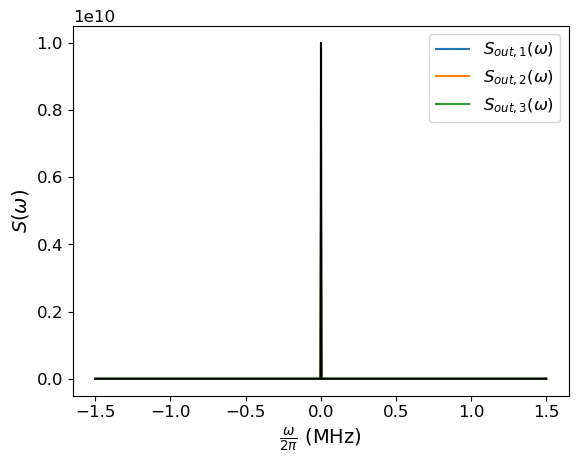

In [26]:
# Plot the results
plt.plot(ω / (2 * np.pi * 1e6), output_1, label='$S_{out,1}(\\omega)$')
plt.plot(ω / (2 * np.pi * 1e6), output_2, label='$S_{out,2}(\\omega)$')
plt.plot(ω / (2 * np.pi * 1e6), output_3, label='$S_{out,3}(\\omega)$')
plt.plot(ω / (2 * np.pi * 1e6), output_1 + output_2 + output_3, color='k')
plt.xlabel("$\\frac{\\omega}{2\\pi}$ (MHz)")
plt.ylabel("$S(\\omega)$")
plt.legend()

In [27]:
(output_1 + output_2 + output_3)[0] / (2*nT + 1 + np.abs(β) ** 2)

7.259875793319885e-09

So this confirms my hypothesis!  Adding back in the NV ensemble should provide the same ratio if we also include an expression for $c_{out}$.  That might be a bit overkill, however.  We should be able to determine the ratio of the input that is reflected or transmitted or lost just using the spectra we have and the fact that we have a total input of $2n_T + n_c + 1 + |\beta|^2$.  Would still be useful to have as a check though

In [28]:
def output_spectrum_b(ω, κ, γ, ϕ, r, g, Δ, nT, nc, β, Sϕ=0):
    """
    Function for calculation the output spectrum from b_out using input/output theory with a coherent input source
    :param ω:  the frequency
    :param κ:  the output coupling rate of the cavity
    :param γ:  the internal loss rate of the cavity
    :param r:  the inhomogenous spreading of the spins
    :param g:  the coupling strength between the cavity and the spin ensemble
    :param Δ:  the detuning between the cavity and the spins
    :param nT: the number of thermal photons in the cavity
    :param nc: the effective number of photons in the spin bath
    :param β:  the amplitude of the coherent state <n> = |β|^2
    :param Sϕ: the phase noise spectrum
    :return:   the output spectrum (photons / freq)
    """
    # Define the terms of the numerator of the first term
    a = ((r ** 2 / 4) + ω ** 2) * (κ * γ * nT + γ * ϕ)
    b = γ * r * g ** 2 * nc
    c = np.abs(((γ - κ - ϕ) / 2 + 1j * (ω - Δ)) * (r / 2 - 1j * ω) - g ** 2) ** 2 * nT
    num = a + b + c

    # Define the denominator of the first term
    den = np.abs(((κ + γ + ϕ) / 2 - 1j * (ω - Δ)) * (r / 2 - 1j * ω) + g ** 2) ** 2

    # Define the second term
    snd_term_num = r ** 2 * γ * κ 
    snd_term_den = 4 * np.abs(((κ + γ + ϕ) / 2 - 1j * (ω - Δ)) * (r / 2 - 1j * ω) + g ** 2) ** 2
    snd_term = snd_term_num / snd_term_den * (np.abs(β) ** 2 * signal.unit_impulse(ω.shape[0], 'mid') + Sϕ)

    # return
    return num / den + snd_term

In [29]:
def output_spectrum_c(ω, κ, γ, ϕ, r, g, Δ, nT, nc, β, Sϕ=0):
    """
    Function for calculation the output spectrum from c_out (into ensemble) using input/output theory with a coherent input source
    :param ω:  the frequency
    :param κ:  the output coupling rate of the cavity
    :param γ:  the internal loss rate of the cavity
    :param r:  the inhomogenous spreading of the spins
    :param g:  the coupling strength between the cavity and the spin ensemble
    :param Δ:  the detuning between the cavity and the spins
    :param nT: the number of thermal photons in the cavity
    :param nc: the effective number of photons in the spin bath
    :param β:  the amplitude of the coherent state <n> = |β|^2
    :param Sϕ: the phase noise spectrum
    :return:   the output spectrum (photons / freq)
    """
    # Define the terms of the numerator of the first term
    a = r * κ * g ** 2 * nT + r * γ * g ** 2 * nT + r * ϕ * g ** 2
    b = np.abs(((κ + γ + ϕ) / 2 - 1j * (ω - Δ)) * (r / 2 + 1j * ω) - g ** 2) ** 2 * nc
    num = a + b

    # Define the denominator of the first term
    den = np.abs(((κ + γ + ϕ) / 2 - 1j * (ω - Δ)) * (r / 2 - 1j * ω) + g ** 2) ** 2

    # Define the second term
    snd_term_num = g ** 2 * r * κ 
    snd_term_den = np.abs(((κ + γ + ϕ) / 2 - 1j * (ω - Δ)) * (r / 2 - 1j * ω) + g ** 2) ** 2
    snd_term = snd_term_num / snd_term_den * (np.abs(β) ** 2 * signal.unit_impulse(ω.shape[0], 'mid') + Sϕ)

    # return
    return num / den + snd_term

In [30]:
output_a = output_spectrum_a(ω, κ, γ, ϕ, r, g, 0, nT, nc, β)
output_e = output_spectrum_e(ω, κ, γ, ϕ, r, g, 0, nT, nc, β)
output_b = output_spectrum_b(ω, κ, γ, ϕ, r, g, 0, nT, nc, β)
output_c = output_spectrum_c(ω, κ, γ, ϕ, r, g, 0, nT, nc, β)

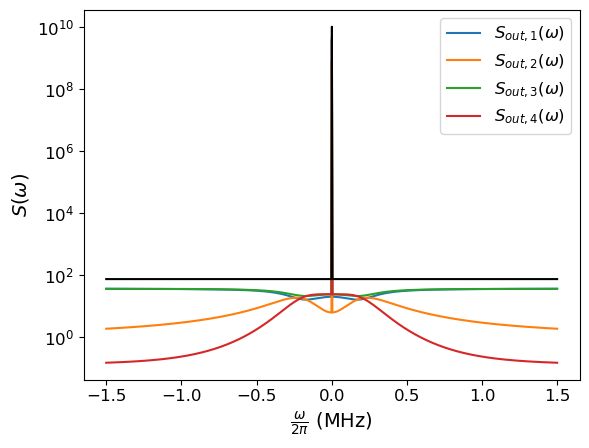

In [31]:
# Plot the results
plt.semilogy(ω / (2 * np.pi * 1e6), output_a, label='$S_{out,1}(\\omega)$')
plt.semilogy(ω / (2 * np.pi * 1e6), output_e, label='$S_{out,2}(\\omega)$')
plt.semilogy(ω / (2 * np.pi * 1e6), output_b, label='$S_{out,3}(\\omega)$')
plt.semilogy(ω / (2 * np.pi * 1e6), output_c, label='$S_{out,4}(\\omega)$')
plt.semilogy(ω / (2 * np.pi * 1e6), output_a + output_e + output_b + output_c, color='k')
plt.xlabel("$\\frac{\\omega}{2\\pi}$ (MHz)")
plt.ylabel("$S(\\omega)$")
plt.legend()

In [32]:
(output_a + output_e + output_b + output_c)[0] / (2 * nT + 1 + nc + np.abs(β) ** 2)

7.2723757931382345e-09

So this works as well!

Now I suppose that we can try to estimate the attenutation in the input signal.  The initial situation is
$|\beta|^2 / (2n_T + n_c + 1 + |\beta|^2)$.  The output we're interested in is just output_e, so we have output_e over the same denominator (I think?).

Text(0, 0.5, '$S_{out,2}(\\omega)$/Initial')

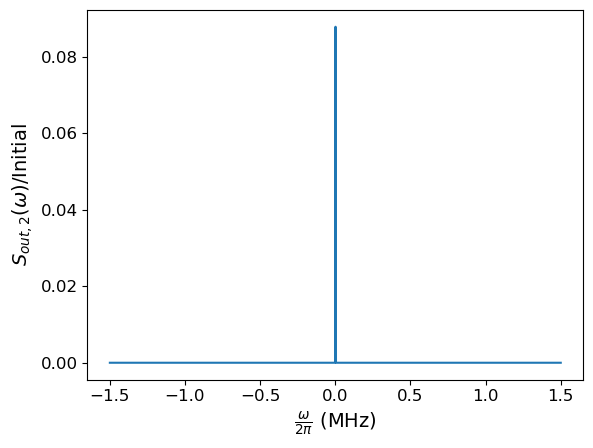

In [33]:
initial = np.abs(β) ** 2 / (2 * nT + 1 + nc + np.abs(β) ** 2)
final = output_e / (2 * nT + 1 + nc + np.abs(β) ** 2)
plt.plot(ω / (2 * np.pi * 1e6), final / initial)
plt.xlabel("$\\frac{\\omega}{2\\pi}$ (MHz)")
plt.ylabel("$S_{out,2}(\\omega)$/Initial")

Kurt suggested that we should be able to look at the noise and signal terms and compare how they've changed after transmission through the cavity to determine how much the SNR has changed.

In [34]:
def output_noise(ω, κ, γ, ϕ, r, g, nT, nc, Δ):
    # The denonminator doesn't change, so we can start by defining that
    den = np.abs(((κ + γ + ϕ) / 2 - 1j * (ω - Δ)) * (r / 2 - 1j * ω) + g ** 2) ** 2

    # There are 4 noise terms
    noise_a = (r ** 2 / 4 + ω ** 2) * ϕ * κ * nT / den
    noise_b = (r ** 2 / 4 + ω ** 2) * ϕ * γ * nT / den
    noise_c = ϕ * r * g ** 2 * nc / den
    noise_e = np.abs(((ϕ - κ - γ) / 2 + 1j * (ω - Δ)) * (r / 2 - 1j * ω) - g ** 2) ** 2 / den

    return noise_a + noise_b + noise_c + noise_e

In [35]:
def output_signal(ω, κ, γ, ϕ, r, g, Δ, β):
    den = np.abs(((κ + γ + ϕ) / 2 - 1j * (ω - Δ)) * (r / 2 - 1j * ω) + g ** 2) ** 2

    return ϕ * κ * r ** 2 * np.abs(β) ** 2 * signal.unit_impulse(ω.shape[0], 'mid') / (4 * den)

In [36]:
# Let's assume for now that we're on resonance so that ω = 0 = Δ
input_s = np.abs(β) ** 2
output_s = output_signal(np.array([0]), κ, γ, ϕ, r, g, 0, β)
print("Input Signal: ", input_s)
print("Output Signal: ", output_s)
print("Ratio: ", output_s / input_s)

Input Signal:  10000000000.0
Output Signal:  [8.78643289e+08]
Ratio:  [0.08786433]


In [37]:
# Now the noise
input_n = nT
output_n = output_noise(0, κ, γ, ϕ, r, g, nT, nc, 0)
print("Input Noise: ", input_n)
print("Output Noise: ", output_n)
print("Ratio: ", output_n / input_n)

Input Noise:  35.79937923012842
Output Noise:  6.086687087471832
Ratio:  0.1700221405612903


In [38]:
print("Initial SNR: ", input_s / input_n)
print("Final SNR: ", output_s / output_n)

Initial SNR:  279334452.58134794
Final SNR:  [1.4435493e+08]


Integrating the spectra with python is a bit tricky because the unit impulse doesn't work exactly like the dirac delta function (i.e. it doesn't integrate to 1).  So we'll have to integrate parts separately

In [39]:
def integrate_output_spectrum_a(ω, κ, γ, ϕ, r, g, Δ, nT, nc, β, Sϕ=0):
    """
    Function for calculating the integral of the output spectrum from port 1 (i.e. reflection) using input/output theory 
    with a coherent input source
    :param ω:  the frequency
    :param κ:  the output coupling rate of the cavity
    :param γ:  the internal loss rate of the cavity
    :param r:  the inhomogenous spreading of the spins
    :param g:  the coupling strength between the cavity and the spin ensemble
    :param Δ:  the detuning between the cavity and the spins
    :param nT: the number of thermal photons in the cavity
    :param nc: the effective number of photons in the spin bath
    :param β:  the amplitude of the coherent state <n> = |β|^2
    :param Sϕ: the phase noise spectrum
    :return:   the output spectrum (photons / freq)
    """
    # Define the terms of the numerator of the first term
    a = ((r ** 2 / 4) + ω ** 2) * (κ * γ * nT + κ * ϕ)
    b = κ * r * g ** 2 * nc
    c = np.abs(((κ - γ - ϕ) / 2 + 1j * (ω - Δ)) * (r / 2 - 1j * ω) - g ** 2) ** 2 * nT
    num = a + b + c

    # Define the denominator of the first term
    den = np.abs(((κ + γ + ϕ) / 2 - 1j * (ω - Δ)) * (r / 2 - 1j * ω) + g ** 2) ** 2

    # Define 1st term and integrate
    fst_term = num / den
    int_fst_term = integrate.simpson(fst_term, x=ω)

    # The integral of the second term is straightforward because of the delta function
    snd_term_num = np.abs(((κ - γ - ϕ) / 2 + 1j * (0 - Δ)) * (r / 2 - 1j * 0) - g ** 2) ** 2 
    snd_term_den = np.abs(((κ + γ + ϕ) / 2 - 1j * (0 - Δ)) * (r / 2 - 1j * 0) + g ** 2) ** 2
    snd_term = snd_term_num / snd_term_den * np.abs(β) ** 2

    # The third term is the integral of the transfer function times the phase noise power spectrum
    thrd_term = integrate.simpson(snd_term_num / snd_term_den * Sϕ, x=ω)

    # return
    return int_fst_term + snd_term + thrd_term

In [40]:
def integrate_output_spectrum_e(ω, κ, γ, ϕ, r, g, Δ, nT, nc, β, Sϕ=0):
    """
    Function for calculation the output spectrum from port 2 (i.e. transmission) using input/output theory with a coherent input source
    :param ω:  the frequency
    :param κ:  the output coupling rate of the cavity
    :param γ:  the internal loss rate of the cavity
    :param r:  the inhomogenous spreading of the spins
    :param g:  the coupling strength between the cavity and the spin ensemble
    :param Δ:  the detuning between the cavity and the spins
    :param nT: the number of thermal photons in the cavity
    :param nc: the effective number of photons in the spin bath
    :param β:  the amplitude of the coherent state <n> = |β|^2
    :param Sϕ: the phase noise power spectrum
    :return:   the output spectrum (photons / freq)
    """
    # Define the terms of the numerator of the first term
    a = ((r ** 2 / 4) + ω ** 2) * ϕ * (κ + γ) * nT
    b = ϕ * r * g ** 2 * nc
    c = np.abs(((ϕ - κ - γ) / 2 + 1j * (ω - Δ)) * (r / 2 - 1j * ω) - g ** 2) ** 2
    num = a + b + c

    # Define the denominator of the first term
    den = np.abs(((κ + γ + ϕ) / 2 - 1j * (ω - Δ)) * (r / 2 - 1j * ω) + g ** 2) ** 2

    # Define the first term and integrate
    fst_term = num / den
    int_fst_term = integrate.simpson(fst_term, x=ω)

    # The integral of the second term is straightforward because of the delta function
    snd_term_num = ϕ * κ * r ** 2
    snd_term_den = 4 * np.abs(((κ + γ + ϕ) / 2 - 1j * (0 - Δ)) * (r / 2 - 1j * 0) + g ** 2) ** 2
    snd_term = snd_term_num / snd_term_den * np.abs(β) ** 2

    # The third term is the integral of the transfer function times the phase noise power spectrum
    thrd_term = integrate.simpson(snd_term_num / snd_term_den * Sϕ, x=ω)

    # return
    return int_fst_term + snd_term + thrd_term

In [41]:
def integrate_output_spectrum_b(ω, κ, γ, ϕ, r, g, Δ, nT, nc, β, Sϕ=0):
    """
    Function for calculation the output spectrum from b_out using input/output theory with a coherent input source
    :param ω:  the frequency
    :param κ:  the output coupling rate of the cavity
    :param γ:  the internal loss rate of the cavity
    :param r:  the inhomogenous spreading of the spins
    :param g:  the coupling strength between the cavity and the spin ensemble
    :param Δ:  the detuning between the cavity and the spins
    :param nT: the number of thermal photons in the cavity
    :param nc: the effective number of photons in the spin bath
    :param β:  the amplitude of the coherent state <n> = |β|^2
    :param Sϕ: the phase noise power spectrum
    :return:   the output spectrum (photons / freq)
    """
    # Define the terms of the numerator of the first term
    a = ((r ** 2 / 4) + ω ** 2) * (κ * γ * nT + γ * ϕ)
    b = γ * r * g ** 2 * nc
    c = np.abs(((γ - κ - ϕ) / 2 + 1j * (ω - Δ)) * (r / 2 - 1j * ω) - g ** 2) ** 2 * nT
    num = a + b + c

    # Define the denominator of the first term
    den = np.abs(((κ + γ + ϕ) / 2 - 1j * (ω - Δ)) * (r / 2 - 1j * ω) + g ** 2) ** 2

    # Define the first term and integrate
    fst_term = num / den
    int_fst_term = integrate.simpson(fst_term, x=ω)

    # The integral of the second term is straightforward because of the delta function
    snd_term_num = r ** 2 * γ * κ 
    snd_term_den = 4 * np.abs(((κ + γ + ϕ) / 2 - 1j * (0 - Δ)) * (r / 2 - 1j * 0) + g ** 2) ** 2
    transfer_func = snd_term_num / snd_term_den
    snd_term = snd_term_num / snd_term_den * np.abs(β) ** 2

    # The third term is the integral of the transfer function times the phase noise power spectrum
    thrd_term = integrate.simpson(snd_term_num / snd_term_den * Sϕ, x=ω)

    # return
    return int_fst_term + snd_term + thrd_term

In [42]:
def integrate_output_spectrum_c(ω, κ, γ, ϕ, r, g, Δ, nT, nc, β, Sϕ):
    """
    Function for calculation the output spectrum from c_out (into ensemble) using input/output theory with a coherent input source
    :param ω:  the frequency
    :param κ:  the output coupling rate of the cavity
    :param γ:  the internal loss rate of the cavity
    :param r:  the inhomogenous spreading of the spins
    :param g:  the coupling strength between the cavity and the spin ensemble
    :param Δ:  the detuning between the cavity and the spins
    :param nT: the number of thermal photons in the cavity
    :param nc: the effective number of photons in the spin bath
    :param β:  the amplitude of the coherent state <n> = |β|^2
    :param Sϕ: the phase power spectrum
    :return:   the output spectrum (photons / freq)
    """
    # Define the terms of the numerator of the first term
    a = r * κ * g ** 2 * nT + r * γ * g ** 2 * nT + r * ϕ * g ** 2
    b = np.abs(((κ + γ + ϕ) / 2 - 1j * (ω - Δ)) * (r / 2 + 1j * ω) - g ** 2) ** 2 * nc
    num = a + b

    # Define the denominator of the first term
    den = np.abs(((κ + γ + ϕ) / 2 - 1j * (ω - Δ)) * (r / 2 - 1j * ω) + g ** 2) ** 2

    # Define the first term and integrate
    fst_term = num / den
    int_fst_term = integrate.simpson(fst_term, x=ω)

    # The integral of the second term is straightforward because of the delta function
    snd_term_num = g ** 2 * r * κ 
    snd_term_den = np.abs(((κ + γ + ϕ) / 2 - 1j * (0 - Δ)) * (r / 2 - 1j * 0) + g ** 2) ** 2
    snd_term = snd_term_num / snd_term_den * np.abs(β) ** 2

    # The third term is the integral of the transfer function times the phase noise power spectrum
    thrd_term = integrate.simpson(snd_term_num / snd_term_den * Sϕ, x=ω)

    # return
    return int_fst_term + snd_term + thrd_term

In [43]:
output_a_photons = integrate_output_spectrum_a(ω, κ, γ, ϕ, r, g, 0, nT, nc, β, np.zeros(ω.shape[0]))
output_e_photons = integrate_output_spectrum_e(ω, κ, γ, ϕ, r, g, 0, nT, nc, β, np.zeros(ω.shape[0]))
output_b_photons = integrate_output_spectrum_b(ω, κ, γ, ϕ, r, g, 0, nT, nc, β, np.zeros(ω.shape[0]))
output_c_photons = integrate_output_spectrum_c(ω, κ, γ, ϕ, r, g, 0, nT, nc, β, np.zeros(ω.shape[0]))

In [44]:
print("Photons from output a: ", output_a_photons)
print("Photons from output e: ", output_e_photons)
print("Photons from output b: ", output_b_photons)
print("Photons from output c: ", output_c_photons)
print("Total: ", output_a_photons + output_e_photons + output_b_photons + output_c_photons)

Photons from output a:  5240402445.215623
Photons from output e:  1002127741.077872
Photons from output b:  1349347645.46488
Photons from output c:  3778932720.1627135
Total:  11370810551.92109


In [45]:
print("nT over bandwidth: ", nT * (ω[-1] - ω[0]))
print("vacuum noise over bandwidth: ", (ω[-1] - ω[0]))
print("nc over bandwidth: ", nc * (ω[-1] - ω[0]))
print("Total input: ", (2 * nT + 1 + nc) * (ω[-1] - ω[0]) + np.abs(β) ** 2)

nT over bandwidth:  674802400.7546788
vacuum noise over bandwidth:  18849555.92153876
nc over bandwidth:  2356194.4901923444
Total input:  11370810551.92109


What do things look like if we include phase noise?

Text(0, 0.5, '$S_\\phi(\\omega)$')

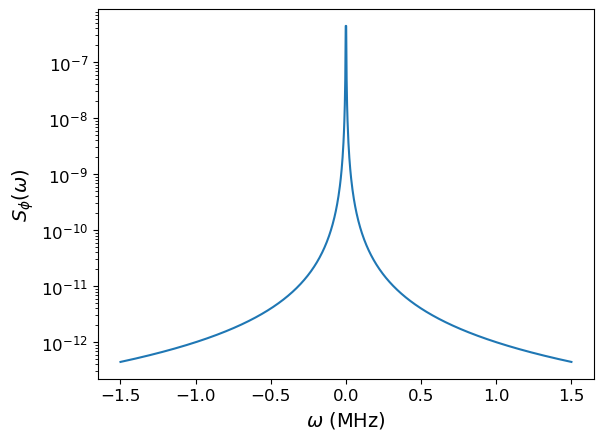

In [46]:
# The phase noise is just from white noise
Sϕ = 4 * np.pi ** 2 / ω ** 2
plt.semilogy(ω / (2 * np.pi * 1e6), Sϕ)
plt.xlabel("$\\omega$ (MHz)")
plt.ylabel("$S_\\phi(\\omega)$")

In [47]:
# Now calculate the output spectra with this phase noise
output_a = output_spectrum_a(ω, κ, γ, ϕ, r, g, 0, nT, nc, β, Sϕ)
output_e = output_spectrum_e(ω, κ, γ, ϕ, r, g, 0, nT, nc, β, Sϕ)
output_b = output_spectrum_b(ω, κ, γ, ϕ, r, g, 0, nT, nc, β, Sϕ)
output_c = output_spectrum_c(ω, κ, γ, ϕ, r, g, 0, nT, nc, β, Sϕ)

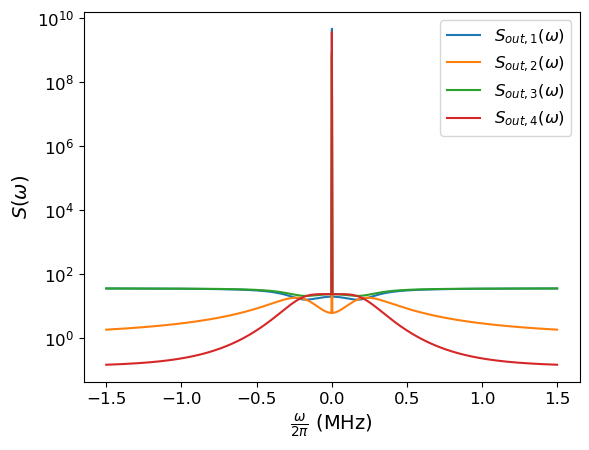

In [48]:
# Plot the spectra
plt.semilogy(ω / (2 * np.pi * 1e6), output_a, label='$S_{out,1}(\\omega)$')
plt.semilogy(ω / (2 * np.pi * 1e6), output_e, label='$S_{out,2}(\\omega)$')
plt.semilogy(ω / (2 * np.pi * 1e6), output_b, label='$S_{out,3}(\\omega)$')
plt.semilogy(ω / (2 * np.pi * 1e6), output_c, label='$S_{out,4}(\\omega)$')
#plt.plot(ω / (2 * np.pi * 1e6), output_a + output_e + output_b + output_c, color='k')
plt.xlabel("$\\frac{\\omega}{2\\pi}$ (MHz)")
plt.ylabel("$S(\\omega)$")
plt.legend()

In [49]:
# Integrate the spectra over the linewidth to get photon numbers for comparison
integral_ω = np.linspace(-γ, γ, 1000)
output_a_photons = integrate_output_spectrum_a(integral_ω, κ, γ, ϕ, r, g, 0, nT, nc, β, Sϕ)
output_e_photons = integrate_output_spectrum_e(integral_ω, κ, γ, ϕ, r, g, 0, nT, nc, β, Sϕ)
output_b_photons = integrate_output_spectrum_b(integral_ω, κ, γ, ϕ, r, g, 0, nT, nc, β, Sϕ)
output_c_photons = integrate_output_spectrum_c(integral_ω, κ, γ, ϕ, r, g, 0, nT, nc, β, Sϕ)

In [50]:
print("Photons from output a: ", output_a_photons)
print("Photons from output e: ", output_e_photons)
print("Photons from output b: ", output_b_photons)
print("Photons from output c: ", output_c_photons)
print("Total: ", output_a_photons + output_e_photons + output_b_photons + output_c_photons)

Photons from output a:  4706352895.1380205
Photons from output e:  893882925.5385307
Photons from output b:  796348958.0197726
Photons from output c:  3731357539.484904
Total:  10127942318.181227


So things don't seem to change too much because the phase noise is too small to have much of an impact.  Ethan suggested that this might be fine.  Apparently there are some devices that can limit phase noise to very small amounts, which should be negligible compared to other noise sources.

Calculate the signal-to-noise ratio of the input (i.e. in port 1) and the output (i.e. port 2).  This will require integrating the noise terms separately from the coherent terms

In [51]:
# Define bounds of integration
ω_bounds = np.linspace(-γ, γ, 1000)

# The input noise consists of the thermal noise entering port input a and the phase noise associated with the coherent input
input_noise_a = (nT) * (ω_bounds[-1] - ω_bounds[0])
input_phase_noise_spectra = 4 * np.pi ** 2 / ω_bounds
input_phase_noise = integrate.simpson(input_phase_noise_spectra, x=ω_bounds)
input_noise = input_noise_a + input_phase_noise
print("Input noise: ", str(10*np.log10(input_noise)) + " dB")

# The input signal is pretty straight forward
input_signal = np.abs(β) ** 2
print("Input signal: ", str(10*np.log10(input_signal)) + " dB")

# So the input snr is
input_snr = input_signal / input_noise
print("Input SNR: ", str(10*np.log10(input_snr)) + " dB")

Input noise:  77.99213110563238 dB
Input signal:  100.0 dB
Input SNR:  22.007868894367626 dB


In [52]:
# Now do the output, which is more involved
a = ((r ** 2 / 4) + ω ** 2) * ϕ * (κ + γ) * nT
b = ϕ * r * g ** 2 * nc
c = np.abs(((ϕ - κ - γ) / 2 + 1j * (ω_bounds - 0)) * (r / 2 - 1j * ω_bounds) - g ** 2) ** 2
num = a + b + c

# Define the denominator of the first term
den = np.abs(((κ + γ + ϕ) / 2 - 1j * (ω_bounds - 0)) * (r / 2 - 1j * ω_bounds) + g ** 2) ** 2

# Output noise from transfer
output_noise_e = integrate.simpson(num / den, x=ω_bounds)

In [53]:
# Output phase noise
coh_term_num = ϕ * κ * r ** 2
coh_term_den = 4 * np.abs(((κ + γ + ϕ) / 2 - 1j * (ω_bounds - 0)) * (r / 2 - 1j * ω_bounds) + g ** 2) ** 2
trans_func = coh_term_num / coh_term_den
output_phase_noise = integrate.simpson(trans_func * Sϕ, x=ω_bounds)

In [54]:
output_noise = output_noise_e + output_phase_noise
print("Output noise: ", str(10*np.log10(output_noise)) + " dB")

Output noise:  87.44097252832825 dB


In [55]:
# The transfer function also applies to the coherent signal, but the integral there is straightforward because of the delta function
coh_term_num = ϕ * κ * r ** 2
coh_term_den = 4 * np.abs(((κ + γ + ϕ) / 2 - 1j * (0 - 0)) * (r / 2 - 1j * 0) + g ** 2) ** 2
trans_func = coh_term_num / coh_term_den
output_signal = trans_func * np.abs(β) ** 2
print("Output signal: ", str(10*np.log10(output_signal)) + " photons")

output_snr = output_signal / output_noise
print("Output SNR: ", str(10*np.log10(output_snr)) + " dB")

Output signal:  89.43812596101847 photons
Output SNR:  1.997153432690209 dB


In [56]:
# Now calculate the ratio of the output snr to the input snr
out_in_rat = output_snr / input_snr
print("Output SNR / Input SNR: ", out_in_rat)

Output SNR / Input SNR:  0.009975357151152256


I'm not sure if the numbers here are correct.  I just used a nice round number for $|\beta|^2$ that I thought was fine compared to $n_T$, but it seems way too small.  Likewise, I'm not sure if the integration over the spectrum should be yielding millions of photons.  It kind of makes sense because the spectra have regions of 1-10 photons / unit frequency and the range is over MHz, but it still seems very large for noise.  Let's check that real quick by assuming we have a 10 mW laser on resonance at 2.98 GHz that sends a 1 s pulse and calculating the expected value of $|\beta|^2$.

In [57]:
P = 10e-3  # W
t = 1      # s
f = 2.98e9 # Hz
N = P * t / (6.626e-34 * f)
print("Number of photons: ", N)

Number of photons:  5.064450193158131e+21


Okay, so that seems like it might be more reasonable to use as our coherent source number of photons, but the SNRs now seem way too large.  Using this value and rerunning everything, it looks like the output SNR is still about 1% of the input SNR, which doesn't seem great for a noiseless attenuator, but I'm not sure of the typical values either.

I went back and converted the SNR's to dB to get a better handle on their values.  Ethan suggested that an SNR of 10 was good, so I fiddled with the number of photons in the coherent input until I got an input SNR of 22 and an output SNR of 2.  The ratio is still about 1%.  It seems like this is because the input signal is attenuated by a lot, while the input noise isn't.  Then when you look at the output you're looking at a smaller number over what is basically the same as in the input (not exactly, but same order of magnitude), so the output SNR is worse.

I changed the signal and noise terms to be dB as well and it seems that I was off a bit.  The input signal is 100 dB and the input noise is 77 dB.  The output signal decreases to 89 dB, but the output noise *increases* to 87 dB.  So passing through the cavity does add noise to the signal.  Maybe that's because I'm only accounting for the thermal noise entering port 1 and ignoring the cavity loss and coupling to the ensemble when I'm looking at the input noise.  Those terms are accounted for in the transfer function representing passage through the cavity (i.e. the coefficients of the noise terms in the output spectrum).

Actually maybe not.  Including them just changed the input noise to 81 instead of 77, but the output noise is still greater.